### Recurrent Neural Network

**RNN** adalah neural network yang bekerja secara sekuensial. Algoritma ini menggunakan output dari sekuens sebelumnya sebagai input untuk digunakan pada sekuens berikutnya. RNN sangat cocok untuk memodelkan data yang bersifat sekuensial seperti time-series dan natural language processing.


Notebook ini mengimplementasikan algoritma RNN untuk memprediksi harga saham IBM.

### Import Library dan Dataset
Data yang digunakan adalah harga saham IBM pada tahun 2006 sampai 2018

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv('/content/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date']) # Menjadikan kolom Date sebagai index
df = df.drop(columns=['Name','Open', 'Close', 'Low', 'Volume']) # Drop kolom yang tidak penting, hanya menggunakan harga saham disaat High
df.head() # Menampilkan 5 data teratas
# Jumlah data adalah 3020

,High
Date,
2006-01-03,82.55
2006-01-04,82.50
2006-01-05,82.90
2006-01-06,85.03
2006-01-09,84.25


### Split dan Normalisasi Data
Data dipisah berdasarkan tahun. 

`train_data` adalah harga saham **sebelum** tahun 2017 sedangkan `test_data` adalah harga saham **setelah** 2017




In [ ]:
# Split data
train_data = df[:'2016']
test_data = df['2017':] 

#### Visualisasi Data Train dan Test
Algoritma RNN diharapkan dapat memprediksi harga saham setelah tahun 2017 (garis hijau)

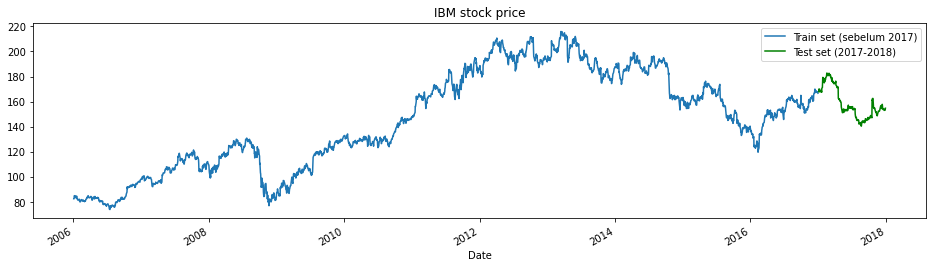

In [ ]:
# Plot graph data train dan test
df["High"][:'2016'].plot(figsize=(16,4),legend=True)
df["High"]['2017':].plot(figsize=(16,4),legend=True, color='green')
plt.legend(['Train set (sebelum 2017)','Test set (2017-2018)'])
plt.title('IBM stock price')
plt.show()

In [ ]:
# Normalisasi data
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)

### Timestep
RNN terdiri dari repetisi beberapa cell. Timestep adalah jumlah dari cell RNN. 

Pada notebook ini `timestep = 60`, yang artinya model RNN memiliki 60 cell.

In [ ]:
n_feature = 1
timestep = 60

X_train = []
y_train = []

# Data train dibagi berdasarkan timestep, sehingga setiap elemen dari training set memiliki 60 data train sebelumnya
for i in range(timestep, len(train_data)):
    X_train.append(scaled_train_data[i-timestep:i, 0])
    y_train.append(scaled_train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

Gambar dibawah adalah ilustrasi cell RNN jika `timestep = 5`

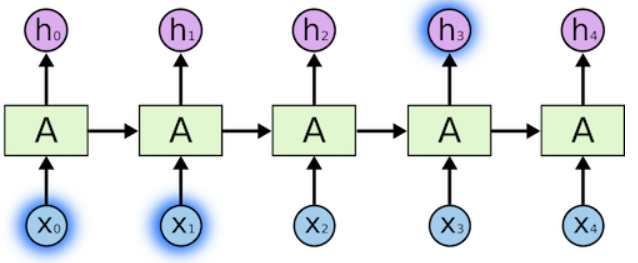

In [ ]:
# Dimensi untuk input model RNN perlu diubah berdasarkan (jumlah data, timesteps, jumlah output)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_feature))
X_train.shape

(2709, 60, 1)

### Pembuatan Moddel
Pada library **Keras** terdapat fungsi yang dapat memodelkan model sekuensial.

Secara garis besar, langkah-langkah untuk membuat model RNN menggunakan library **Keras** adalah sebagai berikut.

* Membuat object model `Sequential`. 
* Masukkan fungsi algoritma RNN `SimpleRNN` ke dalam model sequential dan inputkan parameter yang dibutuhkan. Jika ingin menggunakan beberapa layer RNN, gunakan beberapa fungsi `SimpleRNN`. Untuk notebook ini digunakan satu layer RNN.
* Compile model yang digunakan dengan fungsi Loss dan optimizer yang dibutuhkan

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN

# Inisialisasi object Sequential
rnn_model = Sequential()

# Layer RNN
rnn_model.add(SimpleRNN(units=1, input_shape=(X_train.shape[1], n_feature)))

# Meng-compile RNN
rnn_model.compile(optimizer='rmsprop', loss='mse')

Berikut penjelasan dari beberapa parameter untuk membuat model RNN.
* `units`: Dimensi dari output cell berupa integer. Karena output (prediksi)yang diinginkan hanya menggunakan 1 parameter (pada notebook ini parameternya adalah 'High'), maka nilai `units=1`.

* `input_shape` : Nilai tuple yang mendefinisikan jumlah timestep dan jumlah feature.

* `optimizer` : Metode untuk merubah beberapa atribut dari neural network untuk mengurangi Loss. Beberapa optimizer yang tersedia pada Keras adalah SGD, RMSprop, Adam.

* `loss` : Fungsi Loss yang digunakan pada RNN.


In [ ]:
# Training data
rnn_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
85/85 [==============================] - 1s 7ms/step - loss: 0.1344
Epoch 2/10
85/85 [==============================] - 1s 8ms/step - loss: 0.0808
Epoch 3/10
85/85 [==============================] - 1s 7ms/step - loss: 0.0458
Epoch 4/10
85/85 [==============================] - 1s 7ms/step - loss: 0.0247
Epoch 5/10
85/85 [==============================] - 1s 7ms/step - loss: 0.0118
Epoch 6/10
85/85 [==============================] - 1s 7ms/step - loss: 0.0054
Epoch 7/10
85/85 [==============================] - 1s 7ms/step - loss: 0.0040
Epoch 8/10
85/85 [==============================] - 1s 8ms/step - loss: 0.0037
Epoch 9/10
85/85 [==============================] - 1s 7ms/step - loss: 0.0035
Epoch 10/10
85/85 [==============================] - 1s 7ms/step - loss: 0.0035


### Visualisasi Loss
Terlihat pada visualisasi graph bahwa nilai loss berkurang seiring dengan bertambahnya epoch (perulangan).

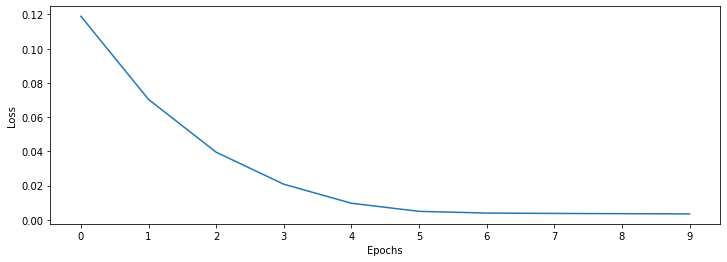

In [ ]:
losses_rnn = rnn_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_rnn)),losses_rnn);

### Prediksi Data Test
Sebelum dilakukan prediksi, data test perlu diolah agar memiliki struktur yang sama seperti data training. 

Jumlah data test (harga saham 2017-2018) perlu ditambah dengan data sebelumnya (harga saham sebelum 2017) sebanyak 60 (jumlah timestep).

In [ ]:
# Menambah data test dengan 60 data test sebelumnya.
dataset_total = df["High"]
test_input = dataset_total[len(dataset_total)-len(test_data) - timestep:].values
test_input = test_input.reshape(-1,1)

# Normalisasi data test
test_input  = scaler.transform(test_input)

In [ ]:
# Data test dibagi berdasarkan timestep, sehingga setiap elemen dari test set memiliki 60 data test sebelumnya
X_test = []
for i in range(timestep, len(test_input)):
    X_test.append(test_input[i-timestep:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_feature))

predicted_stock_price = rnn_model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [ ]:
# Tambahkan kolom baru berupa hasil prediksi kedalam dataframe test_data
test_data = test_data.assign(prediction = predicted_stock_price)
test_data.head()

,High,prediction
Date,,
2017-01-03,167.87,167.836594
2017-01-04,169.87,168.363205
2017-01-05,169.39,169.462540
2017-01-06,169.92,169.477936
2017-01-09,169.80,169.737854


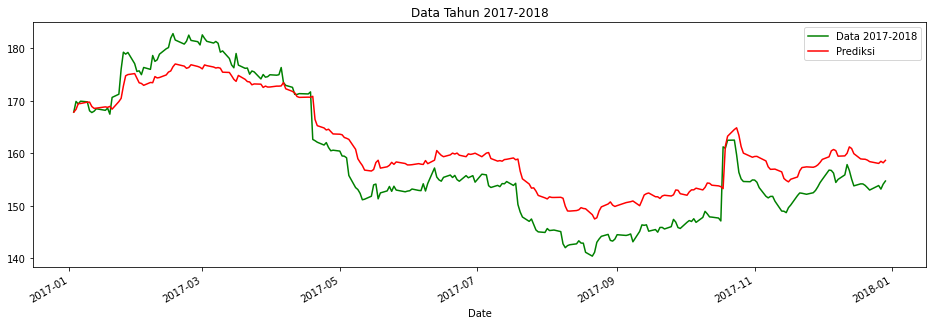

In [ ]:
# Visualisasi hasil prediksi
plt.title('Data Tahun 2017-2018')
test_data['High'].plot(figsize = (16,5), legend=True, color='green')
test_data['prediction'].plot(legend = True, color='red')
plt.legend(['Data 2017-2018','Prediksi'])
plt.show()

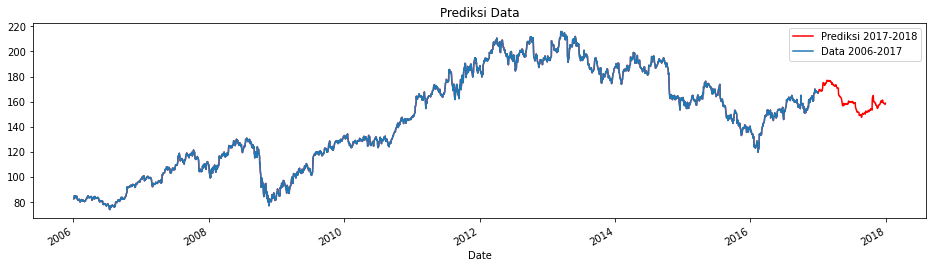

In [ ]:
# Plot data hasil prediksi
concat_pred = pd.concat((df["High"][:'2016'], test_data["prediction"]),axis=0)
concat_pred.plot(figsize=(16,4), legend=True, color='red')
df["High"][:'2016'].plot(figsize=(16,4), legend=True)
plt.legend(['Prediksi 2017-2018','Data 2006-2017'])
plt.title('Prediksi Data')
plt.show()